In [2]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from IPython.display import IFrame
import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.spatial import distance
import cv2
from PIL import Image
import imageio
import glob
import os
from tqdm.auto import tqdm
import time
import faiss
import sqlite3

C:\Users\lizak\anaconda3\envs\big_data\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\lizak\anaconda3\envs\big_data\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\lizak\anaconda3\envs\big_data\lib\site-packages\umap\distances.py:1086: Num

In [3]:
img_width, img_height = 224, 224
train_data_dir = "D:\images"
batch_size = 100

In [4]:
def calculate_histogram(image, color_mode):
    # Check if the color_mode is "hsv"
    if color_mode == "hsv":
        # Convert the image from BGR color space to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # Calculate histogram for the HSV image using OpenCV's calcHist function
        hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8,8,8], [0, 256, 0, 256, 0, 256])
        # Normalize and flatten the histogram
        hist = cv2.normalize(hist, hist).flatten()
        
    # Check if the color_mode is "rgb"
    elif color_mode == "rgb":
        # Convert the image from BGR color space to RGB color space
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR to RGB
        hist = cv2.calcHist([rgb_image], [0, 1, 2], None, [8,8,8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
    else:
        # If the color_mode is neither "hsv" nor "rgb", raise an exception
        raise ValueError(f"Invalid color_mode: {color_mode}")
    return hist

# Image Generator and Feature Extraction

In [3]:
def generator_to_extract_image_features():
    """
    This function extracts image features by utilizing the pre-trained MobileNet model from Keras.
    It also computes and saves HSV and RGB color histograms for the images.
    The function handles image batches for better memory management during the prediction phase.
    Finally, it saves the extracted image features, HSV histograms, RGB histograms, and image paths into .pkl files.
    """
    
    # Lists to hold the image paths, HSV histograms, RGB histograms, and successfully processed images
    Image_paths = []
    hsv = []
    rgb = []
    successful_images = []


    # Define an ImageDataGenerator with a preprocessing function
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    # Load the MobileNet model pre-trained on ImageNet, without the top layer and with average pooling
    model = MobileNet(weights='imagenet', include_top=False, pooling='avg')
    # Define a generator to load images from a directory
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    image_ids = []
    batch_successful_images = []

    # Loop through the filenames generated by the data generator
    for idx, i in tqdm(enumerate(generator.filenames)):
        full_path = os.path.join(train_data_dir, i)

        # Read the image file using OpenCV
        image = cv2.imread(full_path)
        if image is not None:
            try:
                # Resize the image to the target size
                image = cv2.resize(image, (img_width, img_height))
                # Calculate HSV histogram
                hsv_hist = calculate_histogram(image, 'hsv')
                # Calculate RGB histogram
                rgb_hist = calculate_histogram(image, 'rgb')
                # Append the histograms and image path to their respective lists
                hsv.append((idx, hsv_hist))
                rgb.append((idx, rgb_hist))
                Image_paths.append((idx, full_path))
                image_ids.append(idx)
                
                # Preprocess the image for the MobileNet model
                image = preprocess_input(image)
                batch_successful_images.append(image)
                
                # If the batch is full, extract features for the batch
                if len(batch_successful_images) == batch_size:
                    batch_successful_images = np.stack(batch_successful_images, axis=0)
                    batch_extracted_features = model.predict(batch_successful_images)
                    successful_images.extend(batch_extracted_features)
                    batch_successful_images = []

            except:
                print(f"Failed processing {full_path}")
                continue

    # process remaining images if they exist
    if batch_successful_images:
        batch_successful_images = np.stack(batch_successful_images, axis=0)
        batch_extracted_features = model.predict(batch_successful_images)
        successful_images.extend(batch_extracted_features)
    
    # Create DataFrames for HSV and RGB histograms, image paths and extracted features, and save them as .pkl files
    df_hsv = pd.DataFrame(hsv, columns=["ID", "Histogram"])
    df_hsv.to_pickle('ID_hsv_3.pkl')

    df_rgb = pd.DataFrame(rgb, columns=["ID", "Histogram"])
    df_rgb.to_pickle('ID_rgb_3.pkl')

    df_image_paths = pd.DataFrame(Image_paths, columns=["ID", "Path"])
    df_image_paths.to_pickle('ID_path_3.pkl')

    df_extracted_features = pd.DataFrame({
        "ID": image_ids,
        "Embeddings": successful_images
    })
    df_extracted_features.to_pickle('ID_Embeddings_3.pkl')
    
    
# generator_to_extract_image_features()

Found 140392 images belonging to 6 classes.


0it [00:00, ?it/s]

4/4 [==============================] - 1s 161ms/step


4/4 [==============================] - 1s 176ms/step


4/4 [==============================] - 1s 187ms/step


4/4 [==============================] - 1s 186ms/step


3/3 [==============================] - 1s 235ms/step


In [11]:
def update_path(path):
    return path.replace('E:', 'D:')

path_df = pd.read_pickle("ID_path.pkl")
path_df['Path'] = path_df['Path'].apply(lambda x: update_path(x))
path_df

,ID,Path
0,0,D:\images\DIV2k\DIV2K_train_HR\DIV2K_train_HR\...
1,1,D:\images\DIV2k\DIV2K_train_HR\DIV2K_train_HR\...
2,2,D:\images\DIV2k\DIV2K_train_HR\DIV2K_train_HR\...
3,3,D:\images\DIV2k\DIV2K_train_HR\DIV2K_train_HR\...
4,4,D:\images\DIV2k\DIV2K_train_HR\DIV2K_train_HR\...
...,...,...
140384,140387,D:\images\weather_image_recognition\snow\1446.jpg
140385,140388,D:\images\weather_image_recognition\snow\1447.jpg
140386,140389,D:\images\weather_image_recognition\snow\1448.jpg
140387,140390,D:\images\weather_image_recognition\snow\1449.jpg


# Image Recommender  

Recommend images with embeddings, HSV and RGB values.

In [12]:
def save_to_sqlite(df, db_name, table_name):
    """
    This function saves a DataFrame to a SQLite database.

    Parameters:
    df (pandas.DataFrame): The DataFrame to be saved.
    db_name (str): The name of the SQLite database where the DataFrame will be saved.
    table_name (str): The name of the table where the DataFrame will be stored.

    The function connects to a SQLite database (or creates one if it doesn't exist), 
    writes the DataFrame to a specified table within the database (replacing the table if it already exists), 
    and then closes the database connection.
    """
    conn = sqlite3.connect(db_name)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()
    
#save_to_sqlite(path_df, 'paths_db_drive_D.sqlite', 'paths')

In [13]:
def get_paths_from_db(connection, ids):
    """
    This function retrieves file paths associated with a list of IDs from a SQLite database.

    Parameters:
    connection (sqlite3.Connection): The SQLite database connection.
    ids (list): A list of IDs for which to retrieve associated file paths.

    The function iterates over each ID in the provided list, executing a SQL query to fetch 
    the corresponding file path from the 'paths' table in the database. The resulting paths are 
    then appended to a list which is returned by the function.
    """
    paths = []
    for id in ids:
        df = pd.read_sql(f'SELECT * FROM paths WHERE ID = {id}', connection)
        paths.append(df['Path'].values[0])
    return paths


def build_faiss_index(embeddings_df):
    """
    This function constructs a FAISS (Facebook AI Similarity Search) index using a DataFrame 
    containing image embeddings.

    Parameters:
    embeddings_df (pandas.DataFrame): A DataFrame containing image embeddings in the 'Embeddings' column.

    The function first converts the 'Embeddings' column to a list and then to a numpy array. 
    It determines the dimensionality of the embeddings by looking at the shape of the numpy array.
    It then creates a FAISS index with the L2 (Euclidean) distance metric for the determined dimensionality, 
    and adds the embeddings to the index.
    
    Returns:
    index (faiss.swigfaiss.IndexFlatL2): A FAISS index constructed from the image embeddings.
    """
    # Convert the 'Embeddings' column to a list, then to a numpy array, and ensure the type is 'float32'
    embeddings = np.array(embeddings_df['Embeddings'].to_list()).astype('float32')
    # Determine the dimensionality of the embeddings
    dimension = embeddings.shape[1]
    # Create a FAISS index with the L2 distance metric for the determined dimensionality
    index = faiss.IndexFlatL2(dimension)
    # Add the embeddings to the FAISS index
    index.add(embeddings)
    return index


def display_input_and_similar_images(input_image_path, similar_image_paths):
    """
    This function displays an input image and a list of similar images side by side using matplotlib's pyplot.

    Parameters:
    input_image_path (str): The file path of the input image to be displayed.
    similar_image_paths (list): A list of file paths for similar images to be displayed.

    The function first opens and displays the input image, then iterates through the list of similar image paths, 
    opening and displaying each similar image in turn. The input image is titled "Input Image", 
    and the similar images are numbered and titled "Similar Image #".
    """
    plt.figure(figsize=(20, 10))
    img = Image.open(input_image_path)
    plt.subplot(1, len(similar_image_paths) + 1, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    for i, image_path in enumerate(similar_image_paths):
        img = Image.open(image_path)
        plt.subplot(1, len(similar_image_paths) + 1, i+2)
        plt.imshow(img)
        plt.title(f"Similar Image {i+1}")
        plt.axis('off')
    plt.show()
    
    
def euclidean_distance(df, test_color, top_n):
    """
    This function calculates the Euclidean distance between a test color histogram 
    and all color histograms in a DataFrame, and returns the top_n closest histograms.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing color histograms.
    test_color (array-like): The color histogram of the test image.
    top_n (int): The number of closest color histograms to return.

    Returns:
    df (pandas.DataFrame): The DataFrame of top_n closest color histograms, sorted by ascending distance.
    """
    # Calculate Euclidean distance to the test color for each color histogram in the DataFrame
    df['hist_distance'] = df['Histogram'].apply(lambda x: distance.euclidean(test_color, x))
    # Sort the DataFrame by ascending distance
    df.sort_values('hist_distance', inplace=True, ascending=True)
    # Return the top_n closest color histograms
    return df.head(top_n)


def manhattan_distance(df, test_color, top_n):
    """
    This function calculates the Manhattan (or city block) distance between a test color histogram 
    and all color histograms in a DataFrame, and returns the top_n closest histograms.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing color histograms.
    test_color (array-like): The color histogram of the test image.
    top_n (int): The number of closest color histograms to return.

    Returns:
    df (pandas.DataFrame): The DataFrame of top_n closest color histograms, sorted by ascending distance.
    """
    df['hist_distance'] = df['Histogram'].apply(lambda x: distance.cityblock(test_color, x))
    df.sort_values('hist_distance', inplace=True, ascending=True)
    return df.head(top_n)


def cosine_similarity(df, test_color, top_n):
    """
    This function calculates the cosine similarity between a test color histogram 
    and all color histograms in a DataFrame, and returns the top_n most similar histograms.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing color histograms.
    test_color (array-like): The color histogram of the test image.
    top_n (int): The number of most similar color histograms to return.

    Returns:
    df (pandas.DataFrame): The DataFrame of top_n most similar color histograms, sorted by descending similarity.
    """
    df['hist_similarity'] = df['Histogram'].apply(lambda x: 1 - distance.cosine(test_color, x))
    df.sort_values('hist_similarity', inplace=True, ascending=False)
    return df.head(top_n)


def find_similar_images_faiss(index, embeddings_df, test_image_embedding, top_n):
    """
    This function uses a FAISS index to find the most similar images to a test image 
    based on their embeddings, and returns the IDs of the top_n most similar images.

    Parameters:
    index (faiss.swigfaiss.IndexFlatL2): The FAISS index built from the image embeddings.
    embeddings_df (pandas.DataFrame): The DataFrame containing image embeddings and their corresponding IDs.
    test_image_embedding (array-like): The embedding of the test image.
    top_n (int): The number of most similar images to return.

    Returns:
    top_faiss_ids (numpy.ndarray): The IDs of the top_n most similar images.
    """
    # Search the FAISS index for the most similar embeddings to the test image embedding
    D, I = index.search(np.array([test_image_embedding]), top_n)
    # Get the IDs of the most similar images
    top_faiss_ids = embeddings_df.iloc[I[0]]['ID'].values
    # Return the IDs of the most similar images
    return top_faiss_ids


def get_image_embedding(image_path, model):
    """
    This function generates the embedding for a single image using a pretrained model.

    Parameters:
    image_path (str): The file path of the image.
    model (keras.Model): The pretrained model used to generate the image embedding.

    The function reads the image from the file path, resizes it to the input shape of the model, 
    preprocesses it according to the requirements of the model, expands the dimensions to match the 
    input shape of the model, and then generates the embedding by passing the image through the model. 
    The embedding is flattened before it is returned.

    Returns:
    embedding (numpy.ndarray): The embedding of the image, flattened to 1D.
    """
    # Read the image from the file path
    image = cv2.imread(image_path)
    
    # Resize the image to the input shape of the model
    image = cv2.resize(image, (img_width, img_height)) 
    
    # Preprocess the image according to the requirements of the model
    image = preprocess_input(image)
    
    # Expand the dimensions to match the input shape of the model
    image = np.expand_dims(image, axis=0)
    
    # Generate the embedding by passing the image through the model
    embedding = model.predict(image)
    
    # Return the embedding, flattened to 1D
    return embedding.flatten()


def load_dataframes():
    """
    This function loads three DataFrames from pickled files: 'ID_Embeddings.pkl', 'ID_hsv.pkl', and 'ID_rgb.pkl'.

    Returns:
    embeddings_df, hsv_df, rgb_df (pandas.DataFrame): The loaded DataFrames.
    """
    # Load the DataFrame of image embeddings from a pickled file
    embeddings_df = pd.read_pickle('ID_Embeddings.pkl')
    
    # Load the DataFrame of HSV color histograms from a pickled file
    hsv_df = pd.read_pickle('ID_hsv.pkl')
    
    # Load the DataFrame of RGB color histograms from a pickled file
    rgb_df = pd.read_pickle('ID_rgb.pkl')
    
    # Return the loaded DataFrames
    return embeddings_df, hsv_df, rgb_df



def find_all_similarities(test_image_path, top_n=5, type='embeddings'):
    """
    This function finds the most similar images to a test image based on different types of 
    image similarities: embeddings, HSV color histograms, and RGB color histograms.
    
    Parameters:
    test_image_path (str): The file path of the test image.
    top_n (int): The number of most similar images to return.
    type (str): The type of image similarity to use. Options are 'embeddings', 'hsv_euclidean', 'hsv_manhattan', 
                'hsv_cosine', 'rgb_euclidean', 'rgb_manhattan', 'rgb_cosine'. 

    Returns:
    similar_image_ids (list): The IDs of the most similar images.
    """
    # Load the test image
    test_image = cv2.imread(test_image_path)

    # Load the pretrained MobileNet model
    model = MobileNet(weights='imagenet', include_top=False, pooling='avg')
    
    # Calculate the embedding of the test image using the pretrained model
    test_image_embedding = get_image_embedding(test_image_path, model)
    
    if type == 'embeddings':
        # If the similarity type is embeddings, build a FAISS index and search for the most similar images
        index = build_faiss_index(embeddings_df)
        similar_image_ids = find_similar_images_faiss(index, embeddings_df, test_image_embedding, top_n)
        
    elif type in ['hsv_euclidean', 'hsv_manhattan', 'hsv_cosine']:
        # If the similarity type is HSV color histogram, calculate the histogram and search for the most similar images
        test_color = calculate_histogram(test_image, "hsv")
        if type == 'hsv_euclidean':
            top_images = euclidean_distance(hsv_df, test_color, top_n)
        elif type == 'hsv_manhattan':
            top_images = manhattan_distance(hsv_df, test_color, top_n)
        elif type == 'hsv_cosine':
            top_images = cosine_similarity(hsv_df, test_color, top_n)
        similar_image_ids = top_images['ID'].values.tolist()
    
    elif type in ['rgb_euclidean', 'rgb_manhattan', 'rgb_cosine']:
        # If the similarity type is RGB color histogram, calculate the histogram and search for the most similar images
        test_color = calculate_histogram(test_image, "rgb")
        if type == 'rgb_euclidean':
            top_images = euclidean_distance(rgb_df, test_color, top_n)
        elif type == 'rgb_manhattan':
            top_images = manhattan_distance(rgb_df, test_color, top_n)
        elif type == 'rgb_cosine':
            top_images = cosine_similarity(rgb_df, test_color, top_n)
        similar_image_ids = top_images['ID'].values.tolist()
        
    return similar_image_ids



def main():
    global embeddings_df, hsv_df, rgb_df

    # Load data
    embeddings_df, hsv_df, rgb_df = load_dataframes()
    
    # Run the image similarity search
    test_image_path = "wiese.jpg"
    similar_image_ids = find_all_similarities(test_image_path, top_n=6, type='rgb_cosine')
    print(similar_image_ids)
    
    # Get the paths from the SQLite database
    connection = sqlite3.connect('paths_db_drive_D.sqlite')
    similar_image_paths = get_paths_from_db(connection, similar_image_ids)
    
    # Display images
    display_input_and_similar_images(test_image_path, similar_image_paths)


1/1 [==============================] - 0s 453ms/step
[97315, 116069, 94737, 32698, 943, 1613]


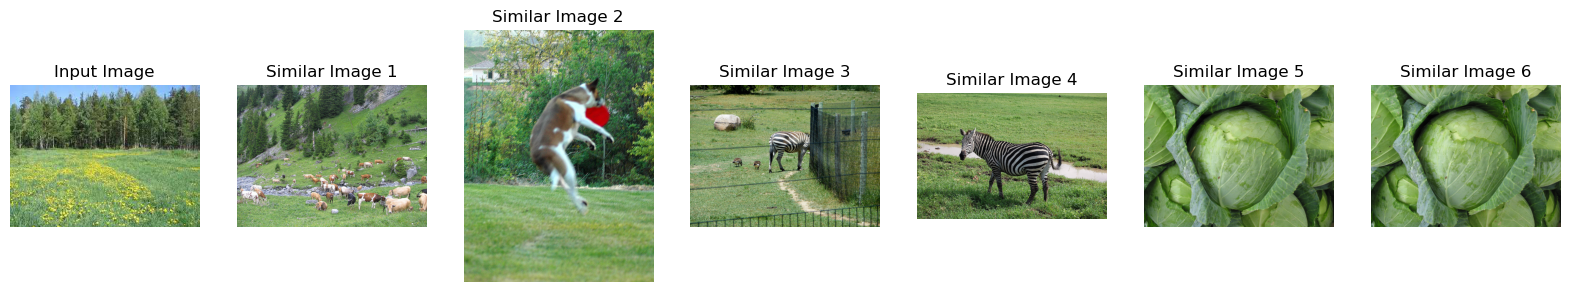

CPU times: total: 13.8 s
Wall time: 13.7 s


In [14]:
%%time
main()

# Dimension reduction

In [15]:
# Convert the 'Embeddings' column from a list to a pandas DataFrame
# embeddings = pd.DataFrame(embeddings_df['Embeddings'].to_list()) # convert 'Embeddings' column to a dataframe

# Concatenate the 'ID' column from the original DataFrame and the newly created 'embeddings' DataFrame
# df = pd.concat([embeddings_df['ID'], embeddings], axis=1) # concat with 'ID' colum

In [17]:
df.to_pickle("dimension_reduction.pkl")

In [19]:
df = pd.read_pickle('dimension_reduction.pkl')

In [20]:
def dimension_reduction(input_data, algo_name="pca", n=2):
    """
    This function reduces the dimension of the input data using the specified algorithm. 
    
    Parameters:
    input_data (pandas.DataFrame): The input data to be reduced. The data should have a column 'ID'.
    algo_name (str): The algorithm used for dimensionality reduction. Options are 'pca', 'umap', and 'tsne'. Default is 'pca'.
    n (int): The number of dimensions to reduce to. Default is 2.

    Returns:
    result (numpy.ndarray): The input data reduced to n dimensions.
    algo_name (str): The algorithm used for dimensionality reduction.
    """
    # Get the values of the input data (excluding the 'ID' column) and convert to float
    embeddings_features = input_data.drop('ID', axis=1).values.astype(float)   
    # If the algorithm is PCA, perform PCA dimensionality reduction
    if algo_name == "pca":
        pca = PCA(n_components=n)
        pca_result = pca.fit_transform(embeddings_features)
        return pca_result, "pca"
    # If the algorithm is UMAP, perform UMAP dimensionality reduction
    elif algo_name == 'umap':
        reducer = umap.UMAP(n_components=n)
        umap_result = reducer.fit_transform(embeddings_features)
        return umap_result, "umap"
    # If the algorithm is t-SNE, perform t-SNE dimensionality reduction
    elif algo_name == 'tsne':
        reducer = TSNE(n_components=n)
        tsne_result = reducer.fit_transform(embeddings_features)
        return tsne_result, "tsne"

In [21]:
def save_data(data, algo_name):
    """
    This function saves the given data to a file. 
    """
    
    np.save(f'{algo_name}.npy', data)
    
def load_reduction_data(algo_name):
    """
    This function loads data from a file if it exists.
    """
    
    if os.path.isfile(f'{algo_name}.npy'):
        return np.load(f'{algo_name}.npy')

In [22]:
def plot_results_interactive(algo_results, ids, algo_name):
    """
    This function creates an interactive scatter plot of the results of dimensionality reduction.
    """
    
    result_df = pd.DataFrame(algo_results, columns=[f"{algo_name}1", f"{algo_name}2"])
    result_df["ID"] = ids

    fig = px.scatter(result_df, x=f"{algo_name}1", y=f"{algo_name}2", hover_data=["ID"])
    fig.update_traces(marker=dict(size=8, opacity=0.1))  # Set marker size and opacity
    fig.update_layout(autosize=False, width=800, height=600)  # Set the size of the plot
    fig.show()

ids = df["ID"]

In [23]:
def apply_clustering(input_data, n_clusters):
    """
    This function applies K-means clustering to the input data.

    Parameters:
    input_data: The input data for clustering. It's expected to have an 'ID' column that won't be used in clustering.
    n_clusters: The number of clusters to form.

    Returns:
    labels (numpy.ndarray): Labels of each point.
    """
    # drop the 'ID' column for clustering
    embeddings_features = input_data.drop('ID', axis=1).values
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(embeddings_features)
    return labels

In [24]:
def display_dimension_reduction_images(similar_image_paths, similar_image_ids):
    plt.figure(figsize=(20, 10))

    for i, image_path in enumerate(similar_image_paths):
        img = Image.open(image_path)
        plt.subplot(1, len(similar_image_paths), i+1)
        plt.imshow(img)
        plt.title(f"Image ID: {similar_image_ids[i]}")  # Use the ID as the title
        plt.axis('off')
        
    plt.show()

## TSNE

In [25]:
tsne_result = load_reduction_data("tsne")

In [26]:
# Display tsne with 50 Kmeans cluster
IFrame(src='interactive_plot_tsne.html', width=1000, height=600)

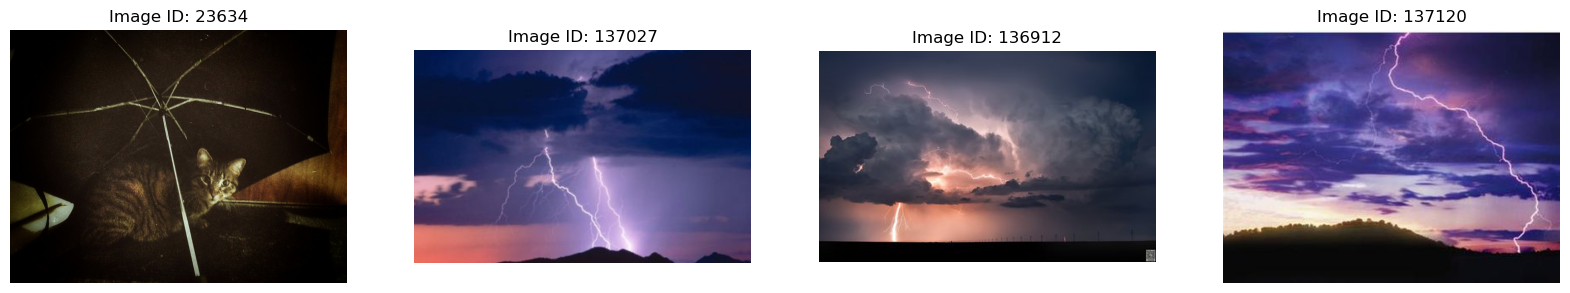

In [27]:
connection = sqlite3.connect('paths_db_drive_D.sqlite')
similar_image_ids = [23634, 137027, 136912, 137120]
similar_image_paths = get_paths_from_db(connection, similar_image_ids)
display_dimension_reduction_images(similar_image_paths, similar_image_ids)

In [29]:
# Display tsne with 100 Kmeans cluster
IFrame(src='interactive_plot_tsne_100.html', width=1000, height=600)

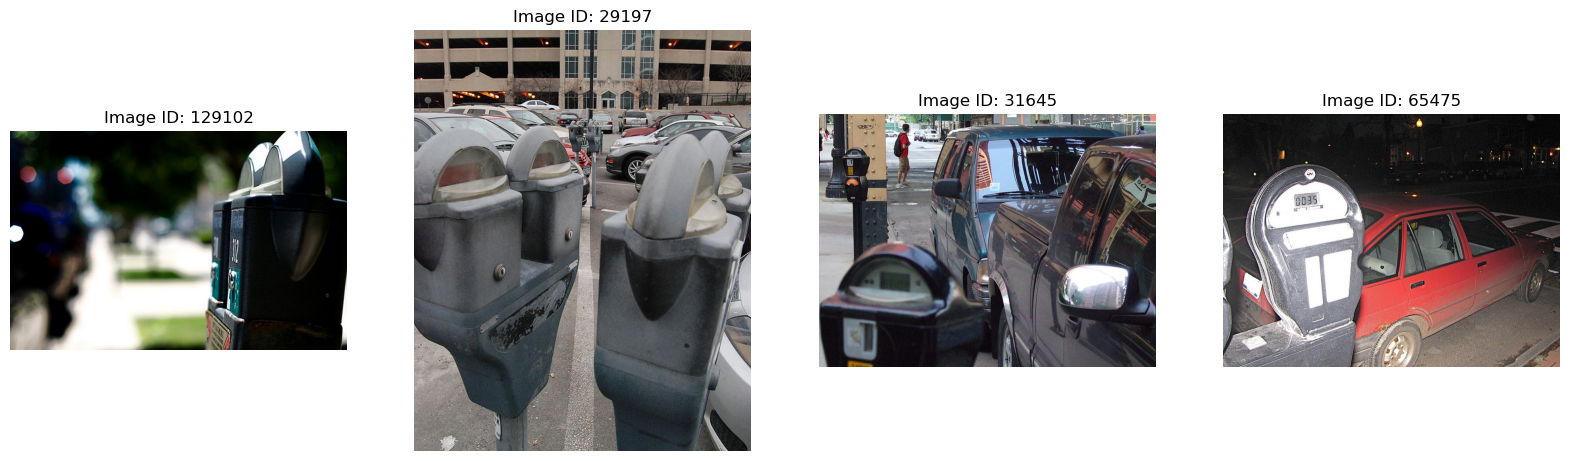

In [30]:
connection = sqlite3.connect('paths_db_drive_D.sqlite')
similar_image_ids = [129102, 29197, 31645, 65475]
similar_image_paths = get_paths_from_db(connection, similar_image_ids)
display_dimension_reduction_images(similar_image_paths, similar_image_ids)

# Umap

In [31]:
# display 50 cluster 
IFrame(src='interactive_plot_umap.html', width=1000, height=600)

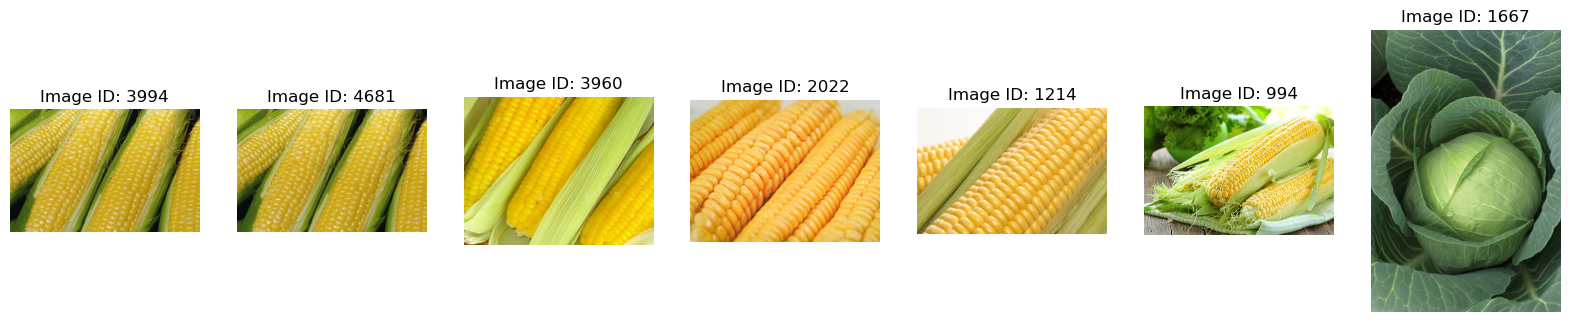

In [33]:
connection = sqlite3.connect('paths_db_drive_D.sqlite')
similar_image_ids = [3994, 4681, 3960, 2022, 1214, 994, 1667]
similar_image_paths = get_paths_from_db(connection, similar_image_ids)
display_dimension_reduction_images(similar_image_paths, similar_image_ids)

In [34]:
# display 100 cluster 
IFrame(src='interactive_plot_umap_100.html', width=1000, height=600)

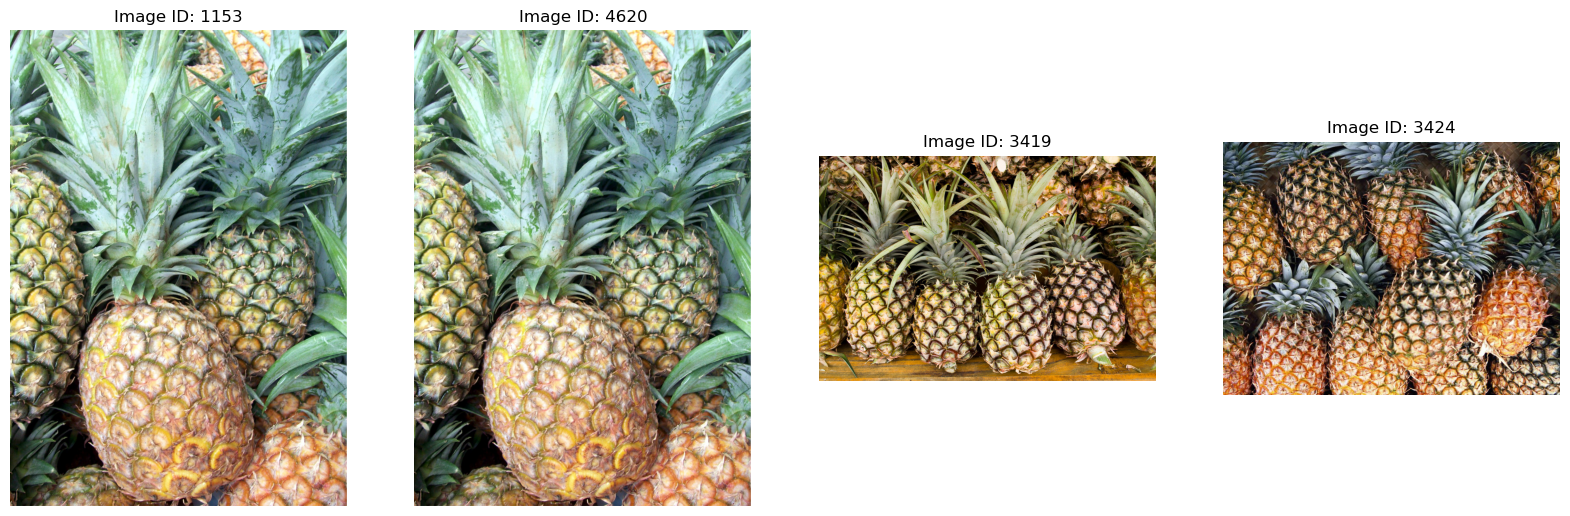

In [35]:
connection = sqlite3.connect('paths_db_drive_D.sqlite')
similar_image_ids = [1153,4620,3419,3424]
similar_image_paths = get_paths_from_db(connection, similar_image_ids)
display_dimension_reduction_images(similar_image_paths, similar_image_ids)

# Test Functions

In [56]:
# Tests: Euclidean distance, Manhattan distance, Cosine similarity
# Generate dummy data for the input for the test functions
n_rows = 5
ids = np.arange(n_rows)
histograms = np.random.random((n_rows, 10)).tolist()

# Create DataFrame
data = {'ID': ids, 'Histogram': histograms}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Generate 10 values in a similar range
color_values = np.random.random(10)

# Print the list of color values
print(color_values.tolist())

def test_euclidean_distance(df, test_color, top_n):
    df_copy = df.copy()  # Create a copy of the dataframe
    
    # Call the euclidean_distance function
    result_df = euclidean_distance(df_copy, test_color, top_n)
    
    # Check if the result has the correct length
    assert len(result_df) == top_n, f"Expected {top_n} similar images, but got {len(result_df)}"
    
    # Check if the distances are calculated correctly
    distances = result_df['hist_distance']
    for distance in distances:
        assert isinstance(distance, float), "Distance should be a float value"

    print("euclidean_distance test passed!")

def test_manhattan_distance(df, test_color, top_n):
    df_copy = df.copy()  # Create a copy of the dataframe
    
    # Call the euclidean_distance function
    result_df = manhattan_distance(df_copy, test_color, top_n)
    
    # Check if the result has the correct length
    assert len(result_df) == top_n, f"Expected {top_n} similar images, but got {len(result_df)}"
    
    # Check if the distances are calculated correctly
    distances = result_df['hist_distance']
    for distance in distances:
        assert isinstance(distance, float), "Distance should be a float value"

    print("manhattan_distance test passed!")

def test_cosine_similarity(df, test_color, top_n):
    df_copy = df.copy()  # Create a copy of the dataframe
    
    # Call the euclidean_distance function
    result_df = cosine_similarity(df_copy, test_color, top_n)
    
    # Check if the result has the correct length
    assert len(result_df) == top_n, f"Expected {top_n} similar images, but got {len(result_df)}"
    
    # Check if the distances are calculated correctly
    distances = result_df['hist_similarity']
    for distance in distances:
        assert isinstance(distance, float), "Distance should be a float value"

    print("cosine_distance test passed!")

   ID                                          Histogram
0   0  [0.4266565657364999, 0.9930279395032985, 0.600...
1   1  [0.3308447810244942, 0.4155024000716515, 0.871...
2   2  [0.050262704291903826, 0.5051290687227455, 0.3...
3   3  [0.0794740868306616, 0.27142650944234825, 0.29...
4   4  [0.33718085873940373, 0.9023038856704938, 0.23...
[0.1837919234081351, 0.9498101850840246, 0.42900201359775136, 0.9809478407151851, 0.24130344201348042, 0.5749582791016562, 0.016799155946490396, 0.39861053034653526, 0.0803298363667222, 0.515284048355837]


In [64]:
# Test: calculating histogram
def test_calculate_histogram():
    # Dummy data
    hsv_image = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)
    rgb_image = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)

    # Call calculate_histogram function for HSV image
    hist_hsv = calculate_histogram(hsv_image, "hsv")
    assert isinstance(hist_hsv, np.ndarray), "Histogram should be a NumPy array"
    assert hist_hsv.shape == (8 * 8 * 8,), "Incorrect shape of HSV histogram"

    # Call calculate_histogram function for RGB image
    hist_rgb = calculate_histogram(rgb_image, "rgb")
    assert isinstance(hist_rgb, np.ndarray), "Histogram should be a NumPy array"
    assert hist_rgb.shape == (8 * 8 * 8,), "Incorrect shape of RGB histogram"

    print("calculate_histogram test passed!")

# Test: Load dataframe from pickle file
def test_load_dataframes():
    # Call the load_dataframes function
    embeddings_df, hsv_df, rgb_df = load_dataframes()

    # Check that the outputs are all DataFrames
    assert isinstance(embeddings_df, pd.DataFrame), "embeddings_df is not a pandas DataFrame"
    assert isinstance(hsv_df, pd.DataFrame), "hsv_df is not a pandas DataFrame"
    assert isinstance(rgb_df, pd.DataFrame), "rgb_df is not a pandas DataFrame"

    # Check that the DataFrames have the expected columns
    assert 'Embeddings' in embeddings_df.columns, "embeddings_df does not have expected 'Embeddings' column"
    assert 'Histogram' in hsv_df.columns, "hsv_df does not have expected 'Histogram' column"
    assert 'Histogram' in rgb_df.columns, "rgb_df does not have expected 'Histogram' column"
    
    # Check that the files from which the dataframes are loaded exist
    assert os.path.isfile('ID_Embeddings_2.pkl'), "File 'ID_Embeddings_2.pkl' does not exist"
    assert os.path.isfile('ID_hsv_2.pkl'), "File 'ID_hsv_2.pkl' does not exist"
    assert os.path.isfile('ID_rgb_2.pkl'), "File 'ID_rgb_2.pkl' does not exist"

    # Check that the dataframes are not empty
    assert not embeddings_df.empty, "embeddings_df is empty"
    assert not hsv_df.empty, "hsv_df is empty"
    assert not rgb_df.empty, "rgb_df is empty"
    
    print("load_dataframes test passed!")

In [58]:
# Tests: functions associated with faiss module
def test_find_similar_images_faiss():
    # Generate some random data for testing
    embeddings_df = pd.DataFrame({
        'ID': [0, 1, 2, 3, 4, 5],
        'Embeddings': [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], [0.2, 0.3, 0.4], [0.5, 0.6, 0.7], [0.8, 0.9, 0.1]]
    })
    test_image_embedding = [0.2, 0.3, 0.4]
    top_n = 3
    
    # Create a sample index
    index = build_faiss_index(embeddings_df)
    
    # Call the find_similar_images_faiss function
    similar_image_ids = find_similar_images_faiss(index, embeddings_df, test_image_embedding, top_n)
    
    # Check if the result has the correct length
    assert len(similar_image_ids) == top_n, f"Expected {top_n} similar image IDs, but got {len(similar_image_ids)}"
    
    # Check if the result contains valid IDs
    assert isinstance(similar_image_ids, np.ndarray), "Similar image IDs should be a numpy array"
    
    print("find_similar_images_faiss test passed!")

    
# Define a test function to test 'build_faiss_index' function
def test_build_faiss_index():
    # Create a DataFrame with 10 rows of embeddings, each embedding is a list of 300 random numbers
    df = pd.DataFrame({
        'Embeddings': [np.random.rand(300).tolist() for _ in range(10)]
    })

    # Call the 'build_faiss_index' function with the created DataFrame
    index = build_faiss_index(df)

    # Assert that the output is an instance of 'faiss.IndexFlatL2', if not, raise an error with the given error message
    assert isinstance(index, faiss.IndexFlatL2), "Index is not a faiss.IndexFlatL2 instance"

    # Assert that the number of vectors in the index is equal to the number of embeddings in the DataFrame
    # If not, raise an error with the given error message
    assert index.ntotal == len(df), "Number of vectors in index does not match number of embeddings"
    
    print("build_faiss_index test passed!")

In [66]:
# Test: Load image paths from database
def test_get_paths_from_db():
    # Create a connection to the SQLite database
    connection = sqlite3.connect('paths_db_3.sqlite')
    
    # Prepare a test list of IDs
    ids = [111, 654, 0]
    
    # Call the get_paths_from_db function
    paths = get_paths_from_db(connection, ids)
    
    # Check that the output is a list
    assert isinstance(paths, list), "Output is not a list"
    
    # Check that the length of the list is correct
    assert len(paths) == len(ids), "Output list has incorrect length"
    
    # Check that all elements in the list are strings (assuming 'Path' column contains strings)
    assert all(isinstance(path, str) for path in paths), "Not all elements in the output list are strings"

    # Close the database connection
    connection.close()
    
    print("Get_paths_from_db test passed!")

In [68]:
# Test: Find similarities between input image and dataset images
def test_find_all_similarities():
    test_image_path = "test.jpg"
    top_n = 5
    type = 'embeddings'
    
    # Test case 1: embeddings
    similar_image_ids = find_all_similarities(test_image_path, top_n, type)
    assert len(similar_image_ids) == top_n, "Test case 1 failed"
    
    # Test case 2: hsv_euclidean
    type = 'hsv_euclidean'
    similar_image_ids = find_all_similarities(test_image_path, top_n, type)
    assert len(similar_image_ids) == top_n, "Test case 2 failed"
    
    # Test case 3: hsv_manhattan
    type = 'hsv_manhattan'
    similar_image_ids = find_all_similarities(test_image_path, top_n, type)
    assert len(similar_image_ids) == top_n, "Test case 3 failed"
    
    # Test case 4: hsv_cosine
    type = 'hsv_cosine'
    similar_image_ids = find_all_similarities(test_image_path, top_n, type)
    assert len(similar_image_ids) == top_n, "Test case 4 failed"
    
    # Test case 5: rgb_euclidean
    type = 'rgb_euclidean'
    similar_image_ids = find_all_similarities(test_image_path, top_n, type)
    assert len(similar_image_ids) == top_n, "Test case 5 failed"
    
    # Test case 6: rgb_manhattan
    type = 'rgb_manhattan'
    similar_image_ids = find_all_similarities(test_image_path, top_n, type)
    assert len(similar_image_ids) == top_n, "Test case 6 failed"
    
    # Test case 7: rgb_cosine
    type = 'rgb_cosine'
    similar_image_ids = find_all_similarities(test_image_path, top_n, type)
    assert len(similar_image_ids) == top_n, "Test case 7 failed"
    
    print("find_all_similarities test passed!")


In [69]:
# Run all tests at once
def run_tests():
    # print messages indicating which test is being run
    # then execute the test function
    
    print("Test euclidean_distance")
    test_euclidean_distance(df, color_values, 3)
    
    print("Test manhattan_distance")
    test_manhattan_distance(df, color_values, 3)
    
    print("Test cosine_distance")
    test_cosine_similarity(df, color_values, 3)
    
    print("Test find_similar_images_faiss")
    test_find_similar_images_faiss()
    
    print("Testing build_faiss_index")
    test_build_faiss_index()
    
    print("Testing calculate_histogram")
    test_calculate_histogram()
    
    print("Testing load_dataframes")
    test_load_dataframes()
    
    print("Testing test_get_paths_from_db")
    test_get_paths_from_db()
    
    print("Testing find_all_similarities")
    test_find_all_similarities()

    # If no errors were raised by the assert statements, print a message indicating that all tests passed
    print("All tests passed")

test = run_tests()

Test euclidean_distance
euclidean_distance test passed!
Test manhattan_distance
manhattan_distance test passed!
Test cosine_distance
cosine_distance test passed!
Test find_similar_images_faiss
find_similar_images_faiss test passed!
Testing build_faiss_index
build_faiss_index test passed!
Testing calculate_histogram
calculate_histogram test passed!
Testing load_dataframes
load_dataframes test passed!
Testing test_get_paths_from_db
Get_paths_from_db test passed!
Testing find_all_similarities
1/1 [==============================] - 0s 322ms/step
Test image embedding dimension: (1024,)
FAISS index dimension: 1024
1/1 [==============================] - 0s 309ms/step
Test image embedding dimension: (1024,)
1/1 [==============================] - 1s 527ms/step
Test image embedding dimension: (1024,)
1/1 [==============================] - 0s 313ms/step
Test image embedding dimension: (1024,)
1/1 [==============================] - 0s 309ms/step
Test image embedding dimension: (1024,)
1/1 [=======